In [20]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [48]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine,inspect,func,distinct

In [5]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurements = Base.classes.measurement
stations = Base.classes.station

In [9]:
# get the column information of each tables
inspector = inspect(engine)
measurement_columns = inspector.get_columns("measurement")
for column in measurement_columns:
    print(column["name"],column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
station_columns = inspector.get_columns("station")
for column in station_columns:
    print(column["name"],column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(bind = engine)

# Exploratory Climate Analysis

### 1.Precipitation Analysis

In [84]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_day = session.query(measurements.date).order_by(measurements.date.desc()).first()[0]
last_day

('2017-08-23')

In [39]:
last_day = dt.datetime.strptime(last_day,"%Y-%m-%d").date()
one_year_ago = last_day.replace(last_day.year-1)
one_year_ago 

datetime.date(2016, 8, 23)

In [40]:
# Perform a query to retrieve the data and precipitation scores
precipitation_12 = session.query(measurements.date,measurements.prcp).filter(measurements.date>=one_year_ago).all()
# Save the query results as a Pandas DataFrame and set the index to the date column

precipitation_df = pd.DataFrame(precipitation_12,columns=['Date','Precipitation Scores'])
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values("Date",ascending=True)
precipitation_df = precipitation_df.dropna(how='any')
precipitation_df = precipitation_df.reset_index(drop=True)
precipitation_df['Precipitation Scores'].max()
count = precipitation_df['Precipitation Scores'].count()
count 

2021

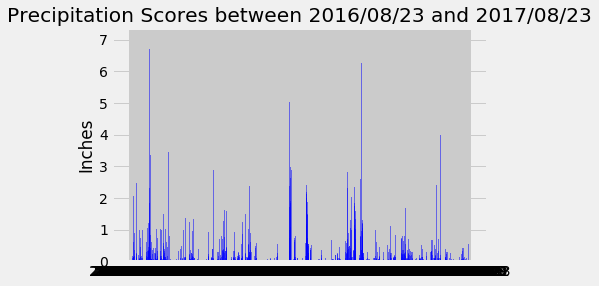

In [154]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.bar(precipitation_df["Date"],precipitation_df["Precipitation Scores"],color='b',alpha=0.5)
plt.title("Precipitation Scores between 2016/08/23 and 2017/08/23")
plot1_ylimb = min(precipitation_df["Precipitation Scores"])*0.9
plot1_ylimt = max(precipitation_df["Precipitation Scores"])*1.1
plt.ylabel("Inches")
plt.ylim(plot1_ylimb,plot1_ylimt)
plot1.set_ylim(plot1_ylimt,plot1_ylimb)
# plt.xticks(range(count-1)[0::200],precipitation_df["Date"][0::200],rotation="vertical")
# plot1.set_xticks()
plt.show()



In [42]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df["Precipitation Scores"].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation Scores, dtype: float64

### 2.Station Analysis

In [70]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(measurements.station).\
                    distinct().count()
print(f"There are {station_count} stations in this dataset.")

There are 9 stations in this dataset.


In [155]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel1 = [measurements.station, 
        func.count(measurements.prcp),]

active_station = session.query(*sel1).\
                    group_by(measurements.station).\
                    order_by(func.count(measurements.prcp).\
                    desc()).first()

# retrieve the information of this most active station.
sel2 = [stations.station,stations.name,stations.latitude,stations.longitude]
active_station_info = session.query(*sel2).filter(stations.station == active_station[0]).all()[0]
print(f"The most active station is {active_station[0]} with {active_station[1]} data points")
print(f"This station is located at {active_station_info[1]}: latitude:{round(active_station_info[2],2)}, longitude:{round(active_station_info[3],2)}")


The most active station is USC00519281 with 2772 data points
This station is located at WAIHEE 837.5, HI US: latitude:21.45, longitude:-157.85


In [149]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel3 = [func.min(measurements.tobs),
        func.max(measurements.tobs),
        func.avg(measurements.tobs)]
active_station_describe = session.query(*sel3).\
                    filter(stations.station == active_station[0]).all()[0]
print(f''' 
    Station ID: {active_station[0]};
    Location: {active_station_info[1]};
    Lowest temperature recorded:{active_station_describe[0]};
    Highest temperature recorded:{active_station_describe[1]};
    Average temperature:{active_station_describe[2]};
''')


 
    Station ID: USC00519281;
    Location: WAIHEE 837.5, HI US;
    Lowest temperature recorded:53.0;
    Highest temperature recorded:87.0;
    Average temperature:73.09795396419437;



Text(0.5, 0, 'Tempreture')

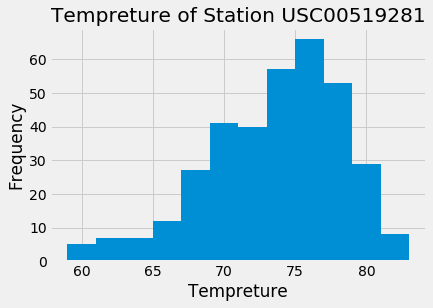

In [153]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel4 = [measurements.date,measurements.tobs]
active_station_tobs = session.query(*sel4).filter(measurements.station == active_station[0]).filter(measurements.date>=one_year_ago).order_by(measurements.date).all()
active_station_tobs
a_tobs = [tobs[1]for tobs in active_station_tobs]
# a_date = [tobs[0]for tobs in active_station_tobs]
# tobs_df = pd.DataFrame({"Date": a_date, "Temperature":a_tobs})
# tobs_df.dropna(how="any")
plt.hist(a_tobs,bins=12)
plt.title(f"Tempreture of Station {active_station[0]}")
plt.ylabel("Frequency")
plt.xlabel("Tempreture")




## Bonus Challenge Assignment

### 1. Temperature Analysis

In [ ]:
pd.real_sql()

### 2. Temperature Analysis

In [156]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurements.tobs), func.avg(measurements.tobs), func.max(measurements.tobs)).\
        filter(measurements.date >= start_date).filter(measurements.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

### 3. Daily Rainfall Average

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurements.tobs), func.avg(measurements.tobs), func.max(measurements.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurements.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
